In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import declarativewidgets as decwidgets
decwidgets.init()
import os
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets
from IPython.display import display
from pmagpy.demag_gui_utilities import *
import subprocess
from hargraves_stream_utilities import *
import sched, time
# from IPython.core import interactiveshell

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
test_log = open('testlog.txt','w')
test_errlog = open('testerrlog.txt','w')
test_log.close()
test_errlog.close()
test_log_path = os.path.abspath('testlog.txt')

In [4]:
def set_hargraves_path(name="~/Dropbox/Hargraves_Data/"):
    global hargraves_path
    hargraves_path = name
    hargraves_path = os.path.expanduser(hargraves_path)
    return hargraves_path
set_hargraves_path();

In [5]:
%%html
<template is="urth-core-bind" channel='a'>
    <urth-core-function id="f" ref="set_hargraves_path" value="{{name}}" auto></urth-core-function>
    <label>Path to Hargraves_Data folder:</label> <input type="text" placeholder="{{name}}" value="{{name::input}}" size="35"></input><br/>
</template> 

In [6]:
def on_name_change(old, new):
    hargraves_path = set_hargraves_path(name=new)
    msg = "{}".format(new)
    decwidgets.channel('a').set('message', msg)
    
decwidgets.channel('a').watch('name', on_name_change)

In [7]:
%%html
<template is='urth-core-bind' channel='a' auto>
    <span>Path changed to {{message}}</span>
</template>

In [51]:
os.path.getctime(test_log_path)

1472244886.0

In [54]:
os.path.getctime(test_log_path)

1472244916.0

In [ ]:
def detect_file_change():
    global test_log_path
    hargraves_path = name
    hargraves_path = os.path.expanduser(hargraves_path)
    return hargraves_path
set_hargraves_path();

In [60]:
%%html
<input type="file" value="testlog.txt" onchange="alert('Changed!');" />

In [ ]:
%%html
<template is="urth-core-bind" channel='b'>
    <urth-core-function id="file" ref="on_file_change" auto></urth-core-function>
    <label>Path to Hargraves_Data folder:</label> <input type="file" value="testlog.txt" onchange="run()"></input><br/>
</template> 

In [36]:
def on_file_change():
    test_log = open(test_log_path, 'r')
    path_name_list = test_log.readlines()
    test_log.close()
    new = path_name_list[-2]+path_name_list[-1]
    try:
        old = path_name_list[-4]+path_name_list[-3]
    except IndexError:
        decwidgets.channel('b').set('update', True)
        return True
    if new == old:
        decwidgets.channel('b').set('update', False)
        return False
    else:
        decwidgets.channel('b').set('update', True)
        return True
decwidgets.channel('b').watch('update', on_file_change)

In [41]:
try:
    on_file_change()
except:
    pass

In [58]:
on_file_change()

True

In [57]:
%%html
<template is='urth-core-bind' channel='b' auto>
    <urth-core-function id="f" ref="on_file_change" result="{{update}}" auto></urth-core-function>
    <span>UPDATE: {{update}}</span>
</template>

In [16]:
def start_stream():
    global stream_status
    stream_status=True
    get_ipython().run_cell_magic(u'sh', u'--proc GETFILES --bg -s "$hargraves_path" "$test_log_path"', u'demag_stream.command $1 $2')
    return stream_status

In [17]:
def shutdown_stream():
    global stream_status
    stream_status=False
    !killall bash
    %killbgscripts
    return stream_status

In [18]:
from declarativewidgets import channel
# t = ipywidgets.widget_selection.ToggleButtons(description='Stream:', options=['On', 'Off'])
# display(t)
stream_status=True
def toggle_stream():
    global stream_status
    stream_status = not stream_status
#     if stream_status is True:
# #         channel('c').set('stream_status', True)
#         start_stream();
#     else:
    if stream_status:
        channel('c').set('stream_status', 'LIVE')
        channel('c').set('stream_clr', 'green')
    else:
        channel('c').set('stream_status', 'DEAD')
        channel('c').set('stream_clr', 'red')
#         shutdown_stream();
    if stream_status:
        return start_stream();
    else:
        return shutdown_stream();
#     return start_stream() if stream_status else shutdown_stream()
decwidgets.channel('c').watch('stream_status', toggle_stream)
decwidgets.channel('c').watch('stream_clr', toggle_stream)

In [19]:
%%capture
@interact()
def stream(Stream=False):
    return toggle_stream();

Starting job # 0 in a separate thread.


True

In [25]:
%%html
<template is='urth-core-bind' channel='c' auto>
    <style>
    strong {color:{{stream_clr}};}
    </style>
    <span><strong>Stream is {{stream_status}}</strong></span>
</template>

In [25]:
def find_most_recent(full_path, test_log_path):
    log = open(test_log_path, 'r')
    path_name_list = log.readlines()
    log.close()
    path_name = path_name_list[-2]+path_name_list[-1]
    dir_path = str(path_name).split('\n')[0][2:]
    file_path = str(path_name).split('\n')[1]
    full_inp_path = os.path.abspath(hargraves_path+'/'+ dir_path + '/' + os.path.basename(dir_path) + '.inp')
    full_sam_path = os.path.abspath(hargraves_path+'/'+ dir_path + '/' + os.path.basename(dir_path) + '.sam')
#     print full_inp_path, '\nexists ---> {}'.format(os.path.isfile(full_inp_path))
#     print full_sam_path, '\nexists ---> {}'.format(os.path.isfile(full_sam_path))
    return full_inp_path, full_sam_path, file_path

In [26]:
try:
    full_inp_path, full_sam_path, file_path = find_most_recent(hargraves_path, test_log_path)
    most_recent_sample = os.path.splitext(os.path.basename(file_path))[0][:-1]
    try:
        most_recent_samp_num = most_recent_sample.split('.')[1]
    except:
        most_recent_samp_num = most_recent_sample.split('-')[1]
except:
    print "No data detected. Turn on stream"

In [27]:
%%capture
%cd
_, er_specimens, er_sites, er_samples, magic_measurements = read_inp(full_inp_path,full_sam_path)

In [28]:
samp_list = []
all_samp = er_samples.er_sample_name.unique().tolist()
try:
    for s in all_samp:
        samp_list.append(s.split('.')[1])
except:
    for s in all_samp:
        samp_list.append(s.split('-')[1])

In [29]:
sample_name = most_recent_sample
specimen_name = sample_name + 'a'
tr = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['treatment_temp'].tolist()
dec = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_dec'].tolist()
inc = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_inc'].tolist()
moment = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_magn_moment'].tolist()

datablock = map(list, zip(tr, dec, inc, moment))

# [tr,dec,inc,int,ZI,rec['measurement_flag'],rec['magic_instrument_codes']]

In [30]:
sample_info = er_samples.ix[er_samples['er_sample_name']==sample_name]
sample_info.reset_index(inplace=True, drop=True)
dec_geo, inc_geo = [], []
dec_tc, inc_tc = [], []
for n in range(len(dec)):
    d, i = pmag.dogeo(dec[n], inc[n], sample_info.sample_azimuth[0], sample_info.sample_dip[0])
    dec_geo.append(d)
    inc_geo.append(i)
for n in range(len(dec_geo)):
    d, i = pmag.dotilt(dec_geo[n], inc_geo[n], sample_info.sample_bed_dip_direction[0], sample_info.sample_bed_dip[0])
    dec_tc.append(d)
    inc_tc.append(i)

In [31]:
#@interact(sample_num = samp_list, crd=['Core', 'Geographic', 'Tilt corrected'])
def plot_equal_area(sample_num = most_recent_samp_num, crd='Geographic'):
    sample = str(sample_num)
    if '-' in str(magic_measurements['er_specimen_name'][0]):
        sample_name = magic_measurements.er_site_name.unique()[0]+'-'+sample
    elif '.' in str(magic_measurements['er_specimen_name'][0]):
        sample_name = magic_measurements.er_site_name.unique()[0]+'.'+sample
    specimen_name = sample_name + 'a'
    tr = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['treatment_temp'].tolist()
    dec = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_dec'].tolist()
    inc = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_inc'].tolist()
    moment = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_magn_moment'].tolist()

    sample_info = er_samples.ix[er_samples['er_sample_name']==sample_name]
    sample_info.reset_index(inplace=True, drop=True)
    dec_geo, inc_geo = [], []
    dec_tc, inc_tc = [], []
    for n in range(len(dec)):
        d, i = pmag.dogeo(dec[n], inc[n], sample_info.sample_azimuth[0], sample_info.sample_dip[0])
        dec_geo.append(d)
        inc_geo.append(i)
    for n in range(len(dec_geo)):
        d, i = pmag.dotilt(dec_geo[n], inc_geo[n], sample_info.sample_bed_dip_direction[0], sample_info.sample_bed_dip[0])
        dec_tc.append(d)
        inc_tc.append(i)

    
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot2grid((1,3), (0,0), colspan=1)
    plt.axis("off")
    plot_net()

    if crd=='Core':
        datablock = map(list, zip(tr, dec, inc, moment))
        ipmag.plot_di(dec,inc)
    elif crd=='Geographic':
        datablock = map(list, zip(tr, dec_geo, inc_geo, moment))
        ipmag.plot_di(dec_geo, inc_geo)
    elif crd=='Tilt corrected':
        datablock = map(list, zip(tr, dec_tc, inc_tc, moment))
        ipmag.plot_di(dec_tc, inc_tc)

    ax2 = plt.subplot2grid((1,3), (0,1), colspan=1)
    plt.axis("off")
    plotZ(datablock, 90, specimen_name, 0)

    ax3 = plt.subplot2grid((1,3), (0,2), colspan=1)
    plt.axis("on")
    plotMT(datablock,specimen_name, 1, 'K',1)
    
    plt.tight_layout()
    plt.show()

In [32]:
import traitlets

In [33]:
dirs = full_sam_path.split('/')
for direct in range(len(dirs)):
    if dirs[direct]=='Hargraves_Data':
        dir_ind = direct + 1
def in_hargraves_file(value):
    options = os.listdir(os.path.abspath(hargraves_path+value))
    return options
dir1 = ipywidgets.Dropdown(options=os.listdir(hargraves_path),value=dirs[dir_ind])
dir2 = ipywidgets.Dropdown(options=os.listdir(os.path.abspath(hargraves_path+dir1.value)),value=dirs[dir_ind+1])
g =ipywidgets.Dropdown(options=samp_list, value=most_recent_samp_num, description="Sample")
coor = ipywidgets.Dropdown(options=['Core', 'Geographic', 'Tilt corrected'], value='Geographic')
dl = traitlets.dlink((dir1, 'value'), (dir2, 'options'), transform=in_hargraves_file)

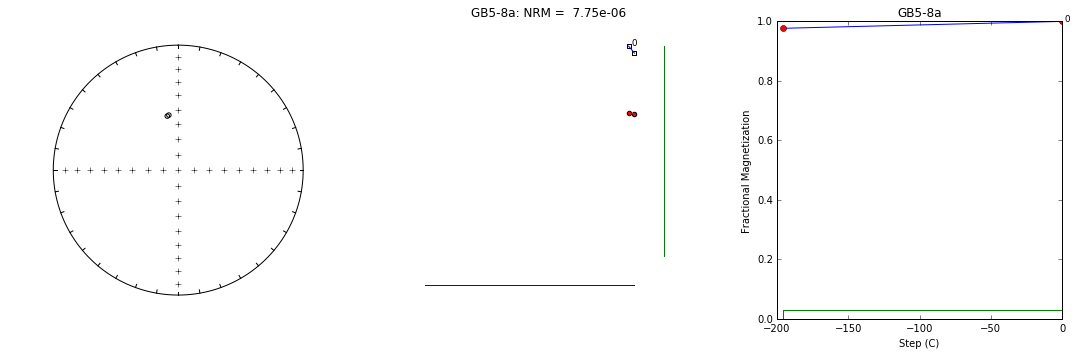

In [34]:
box = ipywidgets.HBox([dir1, dir2])
# display(box)
w = interactive(plot_equal_area, sample_num=g, crd=coor)
display(w)

In [28]:
input_form = """
<div style="border:solid navy; padding:20px;">
<input type="file" id="file_selector" name="files[]"/>
<output id="list"></output>
</div>
"""

javascript = """
<script type="text/Javascript">
  function handleFileSelect(evt) {
    var kernel = IPython.notebook.kernel;
    var files = evt.target.files; // FileList object
    console.log('Executing orig')
    console.log(files)
    // files is a FileList of File objects. List some properties.
    var output = [];
    var f = files[0]
    output.push('<li><strong>', escape(f.name), '</strong> (', f.type || 'n/a', ') - ',
                  f.size, ' bytes, last modified: ',
                  f.lastModifiedDate ? f.lastModifiedDate.toLocaleDateString() : 'n/a',
                  '</_Mli>');
    document.getElementById('list').innerHTML = '<ul>' + output.join('') + '</ul>';
    var command = 'fname = "' + f.name + '"'
    console.log(command)
    kernel.execute(command);
  }

  document.getElementById('file_selector').addEventListener('change', handleFileSelect, false);
</script>
"""

def file_selector():
    from IPython.display import HTML, display
    display(HTML(input_form + javascript))
    return os.path.abspath(fname)